In [1]:
import pandas as pd
import numpy as np
import pickle, json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def score_category(score):
    if score is None:
        return None
    elif score >= 7:
        return 'High'
    elif score >= 4:
        return 'Medium'
    elif score <= 3:
        return 'Low'


def getgenWise_wt_score(df, score_cat):
    """
    Calculate weighted scores for genes based on their score categories.

    This function computes a weighted score for each gene by normalizing the 
    score categories ('High', 'Medium', 'Low') and applying predefined weights:
    - 'High' contributes 1.0
    - 'Medium' contributes 0.7
    - 'Low' contributes 0.3

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing gene information and score categories.
    score_cat : str
        The column name in the DataFrame representing the score categories.

    Returns:
    --------
    pandas.Series
        A Series containing the weighted scores for each gene.
    """
    cat_score = pd.crosstab(df['gene_name'], df[score_cat], normalize=0)
    # multiply factors
    return cat_score.get('High', 0) * 1 + cat_score.get('Medium', 0) * 0.7 + cat_score.get('Low', 0) * 0.3

In [4]:
refData = pd.read_csv("../externalRef/geneSet/gene_source_summary_external_5sources.csv",index_col=0)
print (f"Reference data loaded with shape: {refData.shape}")

Reference data loaded with shape: (507, 6)


In [6]:
# load pubmed counts
pubmed_df_ = pd.read_csv("../data/pubmed_gene_sepsis.csv")
print (f"Pubmed counts loaded with shape: {pubmed_df_.shape}")

Pubmed counts loaded with shape: (932, 8)


# scoring each gene and filtering

In [7]:

with open("../data/PS1_rago4_phi4_ss.pkl", "rb") as f:
    rago4_phi4_df = pickle.load(f)
print(f"PS1 standard loaded with shape: {rago4_phi4_df.shape}")
print (f"Genes investigated in PS1 standard: {rago4_phi4_df['gene_name'].nunique()}")

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/2750473165.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  rago4_phi4_df = pickle.load(f)


PS1 standard loaded with shape: (4872, 26)
Genes investigated in PS1 standard: 609


In [8]:
rago4_phi4_df.columns

Index(['final_answer', 'final_score', 'scientific_explanation',
       'output_tokens', 'total_tokens', 'model', 'query', 'naive_score',
       'naive_justification', 'rag_score', 'rag_justification',
       'rag_node_score', 'rag_noderetrived', 'reference', 'json_key',
       'gene_name', 'RAG_Evaluation_Result', 'RAG_Reasoning',
       'rag_usage.prompt_tokens', 'rag_usage.completion_tokens',
       'rag_usage.total_tokens', 'RAG_evalutator', 'gene_qkey',
       'hybrid_category', 'rag_category', 'naive_category'],
      dtype='object')

# PS1: genes analyze filtered geneset

In [9]:
ps1_naive_response = rago4_phi4_df[['gene_name','json_key','naive_score', 'naive_category']]
print (f"PS1 naive response loaded with shape: {ps1_naive_response.shape}")

PS1 naive response loaded with shape: (4872, 4)


In [10]:
naive_gene_score = pd.DataFrame()
naive_gene_score['naive_score_wt'] = getgenWise_wt_score(ps1_naive_response, 'naive_category')
naive_gene_score.sort_values(by='naive_score_wt', ascending=False, inplace=True)

naive_gene_score['qcut_percentile'] = pd.qcut(naive_gene_score['naive_score_wt'], 5, labels=[5, 4, 3, 2, 1])
qcut_color = {5:'#1f78b4',4:'#a6cee3',3:'#b2df8a',2:'#f4a582',1:'#ca0020'}
naive_gene_score['gene_cluster'] = naive_gene_score['qcut_percentile'].map(qcut_color)

## Figure 3A : distribution of PS1 scores

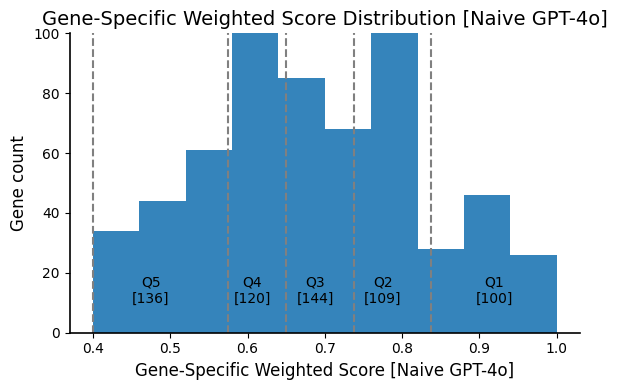

In [11]:
naive_gene_score['naive_score_wt'].plot(kind="hist", bins=10, figsize=(6, 4), color='#1f77b4',alpha=0.9)
plt.ylim(0, 100)
# Add boundary lines and text annotations for quantiles
for i in range(1, 6):
    boundary = naive_gene_score[naive_gene_score['qcut_percentile'] == i]['naive_score_wt'].min()
    plt.axvline(boundary, color='gray', linestyle='--')
    num_genes = naive_gene_score[naive_gene_score['qcut_percentile'] == i].shape[0]
    mid_boundary = (boundary + naive_gene_score[naive_gene_score['qcut_percentile'] == i]['naive_score_wt'].max()) / 2
    plt.text(mid_boundary, plt.ylim()[1] * 0.1, f'Q{i}\n[{num_genes}]', color='k', rotation=0, ha='center', fontsize=10)

plt.xlabel('Gene-Specific Weighted Score [Naive GPT-4o]', fontsize=12)
plt.ylabel('Gene count', fontsize=12)
# Beautify plots
for ax in plt.gcf().axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.title('Gene-Specific Weighted Score Distribution [Naive GPT-4o]', fontsize=14)
plt.tight_layout()
# plt.savefig("./output/Figures/Fig2_naive_gene_score_distribution.pdf", dpi=300)
plt.show()

**Figure X. Gene-Specific Weighted Score Distribution [Naive GPT-4o]**
Histogram showing the distribution of gene-specific weighted scores assigned by the Naive GPT-4o model. Genes are grouped into five quantile-based clusters (Q1–Q5), indicated by vertical dashed lines. Each cluster label displays the quantile (Q1 = highest scores, Q5 = lowest) and the number of genes in that cluster. This visualization highlights the stratification of gene prioritization based on LLM-derived evidence scores.

In [12]:
gpt_4onaive = ps1_naive_response.pivot_table(index='gene_name', columns='json_key', values='naive_score')
gpt_4onaive.fillna(0, inplace=True)

gpt_4onaive.columns
col_rename = {"sepsis_pathogenesis":"a_pathogenesis",
"sepsis_immune":"b_host_immune_response",
"sepsis_organ":"c_organ_dysfunction",
"sepsis_circulating_leukocytes_immune":"d_circulating_leukocytes_immune",
"sepsis_biomarker_clinic":"e_biomarker_clinic",
"sepsis_biomarker_blood":"f_biomarker_blood",
"sepsis_drug":"g_drug_target",
"sepsis_therapeutic":"h_therapeutic"}
gpt_4onaive.rename(columns=col_rename, inplace=True)
gpt_4onaive = gpt_4onaive.loc[naive_gene_score.index].copy()

gpt_4onaive = gpt_4onaive[sorted(gpt_4onaive.columns)]

## Figure 3B : heatmap raw score and clusters

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/1219821078.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_labels = naive_gene_score.groupby('gene_cluster')['qcut_percentile'].first()


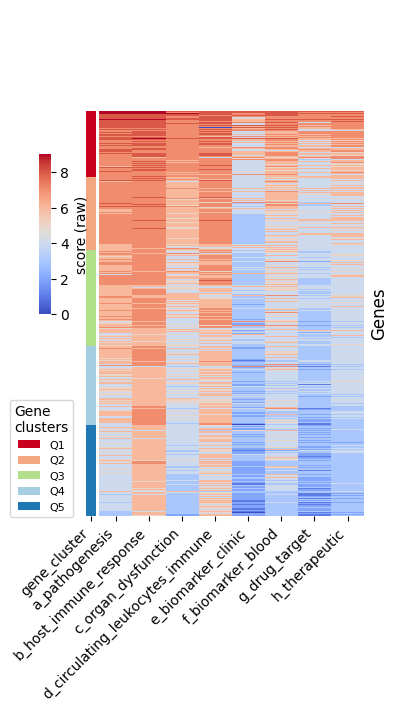

In [13]:
g = sns.clustermap(
    gpt_4onaive.loc[naive_gene_score.index],
    method="ward",
    cmap="coolwarm",
    figsize=(4, 8),
    cbar_kws={"label": "score (raw)"},
    row_colors=naive_gene_score['gene_cluster'],
    row_linkage=None,
    row_cluster=False,
    col_cluster=False,
    xticklabels=True,
    yticklabels=False
)

# Remove the default row colors legend to prevent overlap (safer approach)
try:
    # Try different ways to remove the row colors legend
    if hasattr(g.ax_row_colors, 'legend_'):
        g.ax_row_colors.legend_.remove()
    
    # Alternative approach: hide the row colors axes labels
    g.ax_row_colors.set_xticks([])
    g.ax_row_colors.set_yticks([])
    g.ax_row_colors.set_xlabel('')
    g.ax_row_colors.set_ylabel('')
    
    # Remove any existing legends from row colors
    for text in g.ax_row_colors.texts:
        text.set_visible(False)
        
except AttributeError:
    # If the above doesn't work, just continue
    pass

# Add a separate label for clusters
g.ax_heatmap.set_ylabel("Genes", fontsize=12)
g.ax_heatmap.set_xlabel('')

# Adjust the position of the color bar
cbar = g.ax_cbar
cbar.set_position([0.1, 0.6, 0.03, 0.2])

# Create a separate legend for row colors
# Get unique colors and their corresponding labels
unique_colors = naive_gene_score['gene_cluster'].unique()
unique_labels = naive_gene_score.groupby('gene_cluster')['qcut_percentile'].first()

# Create legend handles
from matplotlib.patches import Patch
legend_handles = [Patch(facecolor=color, label=f'Q{unique_labels[color]}') 
                  for color in unique_colors]

# Add the legend to the figure (positioned to avoid overlap and reduced size)
g.fig.legend(handles=legend_handles, 
             title='Gene\nclusters',
             ncol=1,
             bbox_to_anchor=(0.2, 0.5),
             shadow=False,
             fontsize=8,  # Reduce font size
             title_fontsize=10)  # Reduce title font size

# Beautify plots
for ax in g.ax_heatmap.figure.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.tick_params(axis='both', which='major', labelsize=10)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)
# rotate row_color lables
plt.setp(g.ax_row_colors.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=10)

# plt.tight_layout()
# plt.savefig("./output/Figures/Fig2B_naive_gene_score_clustermap.pdf", dpi=300)
plt.show()

# PS1 : Functional Enrichment

In [18]:
!pip install gseapy --quiet

In [14]:
import gseapy as gp
geneset_loc ="../externalRef/geneSet/"
kegg_gs = gp.read_gmt(geneset_loc + "KEGG_2021_Human.gmt")
# gobp_gs = gp.read_gmt(geneset_loc + "GO_Biological_Process_2025.gmt")
# gocc_gs = gp.read_gmt(geneset_loc + "GO_Cellular_Component_2025.gmt")
# gomf_gs = gp.read_gmt(geneset_loc + "GO_Molecular_Function_2025.gmt")
msigdb_gs = gp.read_gmt(geneset_loc + "MSigDB_Hallmark_2020.gmt")
disgenet_gs = gp.read_gmt(geneset_loc + "DisGeNET.gmt")

In [15]:
bg3_data = pd.read_csv(geneset_loc + "ModuleTranscript_BioINfo.csv")
import ast
# convert string representation of list to actual list
bg3_data['geneList'] = bg3_data['Member genes'].apply(lambda x: [gene.strip() for gene in x.split(", ")])
# explode the geneList to have one gene per row
bg3_data = bg3_data.explode('geneList')
# reset index
bg3_data = bg3_data.reset_index()
aggregate_dict = bg3_data.groupby("Aggregate number")['geneList'].apply('unique').to_dict()
aggregate_dict_function = bg3_data.groupby("Aggregate number")['Module title'].apply('unique').to_dict()
bg3_data['Module_title'] = bg3_data['Module title']+"_"+bg3_data["ID"]

bg3_modules = bg3_data.groupby("Module_title")['geneList'].apply('unique').to_dict()

## Get back ground and all known genes

In [16]:
disgenet_enricher = pd.DataFrame(disgenet_gs.items(), columns=["GeneSet", "Genes"])

disgenet_enricher_sepsis = disgenet_enricher[disgenet_enricher.GeneSet.str.contains("(?i)Sepsis")]
# get unique genes
disgenet_enricher_sepsis_genes = set()
for genes in disgenet_enricher_sepsis.Genes:
    disgenet_enricher_sepsis_genes.update(genes)  # Directly iterate over the list
disgenet_enricher_sepsis_genes = pd.Series(list(disgenet_enricher_sepsis_genes))
# check how many genes are in naive_gene_score
disgenet_enricher_sepsis_genes_in_naive = disgenet_enricher_sepsis_genes[disgenet_enricher_sepsis_genes.isin(naive_gene_score.index)]
print("DisGeNET Sepsis genes in naive_gene_score:", disgenet_enricher_sepsis_genes_in_naive.shape[0], "out of", disgenet_enricher_sepsis_genes.shape[0])    

# seps whole including all genes from disgenet + refdata
sepsis_whole = set(disgenet_enricher_sepsis_genes.values).union(set(refData.index))
print ("Sepsis whole genes:", len(sepsis_whole))

# naive llm geneset 
nllm_gs = list(naive_gene_score.index.unique())
print ("Naive LLM genes:", len(nllm_gs))

DisGeNET Sepsis genes in naive_gene_score: 203 out of 555
Sepsis whole genes: 929
Naive LLM genes: 609


In [17]:
# make a gene set dictionary for enrichment analysis
gene_set_dict = {"PS1_gene_naiveLLM": nllm_gs,"known_genes": list(sepsis_whole)}

## MolSigDB

In [18]:
# for whole sepsis genes
enr_msigdb_whole = gp.enrichr(gene_list=list(sepsis_whole), gene_sets=[msigdb_gs], organism='Human', cutoff=0.05)
enr_msigdb_whole = enr_msigdb_whole.results.sort_values(by='Adjusted P-value', ascending=True)
enr_msigdb_whole = enr_msigdb_whole[enr_msigdb_whole['Adjusted P-value'] < 0.05]

# for nllm genes
enr_msigdb_nllm = gp.enrichr(gene_list=list(nllm_gs), gene_sets=[msigdb_gs], organism='Human', cutoff=0.05)
enr_msigdb_nllm = enr_msigdb_nllm.results.sort_values(by='Adjusted P-value', ascending=True)
enr_msigdb_nllm = enr_msigdb_nllm[enr_msigdb_nllm['Adjusted P-value'] < 0.05]   
print("Enriched MSigDB Hallmark terms for whole sepsis genes:")
print(enr_msigdb_whole.shape[0], "terms found")
print("Enriched MSigDB Hallmark terms for NLLM genes:")
print(enr_msigdb_nllm.shape[0], "terms found")


Enriched MSigDB Hallmark terms for whole sepsis genes:
12 terms found
Enriched MSigDB Hallmark terms for NLLM genes:
16 terms found


In [19]:
enr_msigdb_whole_ds = enr_msigdb_whole[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
enr_msigdb_nllm_ds = enr_msigdb_nllm[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()

# map category
pathway_category = {
    'Interferon Gamma Response': 'Inflammatory / Cytokine Signaling',
    'Allograft Rejection': 'Adaptive / Alloimmunity',
    'Inflammatory Response': 'General Immune Activation',
    'TNF-alpha Signaling via NF-kB': 'Inflammatory / Cytokine Signaling',
    'IL-6/JAK/STAT3 Signaling': 'Inflammatory / Cytokine Signaling',
    'Complement': 'Complement / Coagulation',
    'Apoptosis': 'Cell Stress / Death',
    'Interferon Alpha Response': 'Inflammatory / Cytokine Signaling',
    'IL-2/STAT5 Signaling': 'Inflammatory / Cytokine Signaling',
    'Coagulation': 'Complement / Coagulation',
    'PI3K/AKT/mTOR  Signaling': 'Signal Transduction',
    'KRAS Signaling Up': 'Signal Transduction',
    'Epithelial Mesenchymal Transition': 'Tissue Remodeling / EMT',
    'Hypoxia': 'Cell Stress / Death',
    'Reactive Oxygen Species Pathway': 'Cell Stress / Death',
    'Oxidative Phosphorylation': 'Cell Stress / Death',
    'TGF-beta Signaling': 'Signal Transduction'
}



enr_msigdb_whole_ds['Category'] = enr_msigdb_whole_ds["Term"].map(pathway_category)
enr_msigdb_nllm_ds['Category'] = enr_msigdb_nllm_ds["Term"].map(pathway_category)
enr_msigdb_whole_ds.sort_values(by=['Category','Adjusted P-value'], ascending=True, inplace=True)

enr_msigdb_nllm_ds.set_index('Term',inplace=True)
enr_msigdb_whole_ds.set_index('Term',inplace=True)
# join the two dataframes
enr_msigdb_combined = enr_msigdb_nllm_ds.join(enr_msigdb_whole_ds, lsuffix='_nllm', rsuffix='_whole', how='outer')
enr_msigdb_combined.reset_index(inplace=True)
enr_msigdb_combined.rename(columns={'index': 'Term'}, inplace=True)

In [20]:
enr_msigdb_combined = enr_msigdb_nllm_ds[['Overlap','Adjusted P-value','Odds Ratio']].join(
    enr_msigdb_whole_ds[['Overlap','Adjusted P-value','Odds Ratio']],
    lsuffix='_nllm', rsuffix='_whole', how='outer'
).reset_index().rename(columns={'index': 'Term'}).set_index('Term')

# add category
enr_msigdb_combined['Category'] = enr_msigdb_combined.index.map(pathway_category)
enr_msigdb_combined.sort_values(by=['Category','Adjusted P-value_nllm'], ascending=True, inplace=True)

or_melt = enr_msigdb_combined[['Odds Ratio_nllm','Odds Ratio_whole','Category']].reset_index().melt(
    id_vars=['Category',"Term"],
    var_name='Source',
    value_name='Odds Ratio'
).sort_values(by=['Category','Source'])

or_melt['Source'] = or_melt['Source'].str.replace('Odds Ratio_', '', regex=False)

or_melt['Source']= or_melt['Source'].map({'nllm': 'naive LLM (PS1)', 'whole': 'Sepsis [Eval. set]'})
source_color = {'naive LLM (PS1)': '#1f77b4', 'Sepsis [Eval. set]': '#ff7f0e'}

## Figure 3C : MolSigDB whole Vs PS1 genes

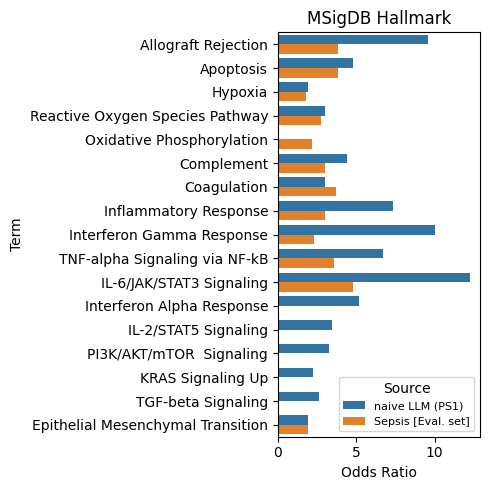

In [21]:
# make horizontal bar plot with odds ratio as x and Term as y
plt.figure(figsize=(5, 5))
sns.barplot(data=or_melt, x='Odds Ratio', y='Term', hue='Source', dodge=True, palette=source_color)
plt.ylabel('Term')
plt.title('MSigDB Hallmark')
plt.legend(title='Source', loc='lower right', fontsize=8)
plt.tight_layout()

# plt.savefig("./output/Figures/Fig2C_msigdb_odds_ratio_terms.pdf", dpi=300)
plt.show()
# or_melt

## BG3 data enrichment

### Aggregate level

In [22]:
enr_bg3_whole = gp.enrichr(gene_list=list(sepsis_whole), gene_sets=[aggregate_dict], organism='Human', cutoff=0.05)
enr_bg3_whole = enr_bg3_whole.results.sort_values(by='Adjusted P-value', ascending=True)
enr_bg3_whole = enr_bg3_whole[enr_bg3_whole['Adjusted P-value'] < 0.05]  
enr_bg3_whole.head()
enr_bg3_nllm = gp.enrichr(gene_list=list(nllm_gs), gene_sets=[aggregate_dict], organism='Human', cutoff=0.05)
enr_bg3_nllm = enr_bg3_nllm.results.sort_values(by='Adjusted P-value', ascending=True)
enr_bg3_nllm = enr_bg3_nllm[enr_bg3_nllm['Adjusted P-value'] < 0.05]  
enr_bg3_nllm.head()
enr_bg3_nllm_ds = enr_bg3_nllm[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
enr_bg3_whole_ds = enr_bg3_whole[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()

enr_bg3_whole = gp.enrichr(gene_list=list(sepsis_whole), gene_sets=[aggregate_dict], organism='Human', cutoff=0.1)
enr_bg3_whole = enr_bg3_whole.results.sort_values(by='Adjusted P-value', ascending=True)
enr_bg3_whole = enr_bg3_whole[enr_bg3_whole['Adjusted P-value'] < 0.1] 

print (enr_bg3_nllm_ds)
print (enr_bg3_whole_ds)

   index Term   Overlap  Adjusted P-value  Odds Ratio
0     24  A35   126/709      5.378379e-39    5.276882
1     16  A28    33/111      1.067086e-16    8.937044
2     22  A33  105/1083      9.017337e-12    2.405033
3     27  A38     14/90      7.666558e-04    3.829535
   index Term  Overlap  Adjusted P-value  Odds Ratio
0     23  A35   79/709      5.364960e-15    3.320808
1     21  A33  76/1083      3.441144e-05    1.912434
2     15  A28   12/111      2.211386e-02    2.972108
3     22  A34   11/103      2.768222e-02    2.936775


### Module level

In [23]:
enr_bg3_whole = gp.enrichr(gene_list=list(sepsis_whole), gene_sets=[bg3_modules], organism='Human', cutoff=0.05)
enr_bg3_whole = enr_bg3_whole.results.sort_values(by='Adjusted P-value', ascending=True)
enr_bg3_whole = enr_bg3_whole[enr_bg3_whole['Adjusted P-value'] < 0.05]  
enr_bg3_whole.head()
enr_bg3_nllm = gp.enrichr(gene_list=list(nllm_gs), gene_sets=[bg3_modules], organism='Human', cutoff=0.05)
enr_bg3_nllm = enr_bg3_nllm.results.sort_values(by='Adjusted P-value', ascending=True)
enr_bg3_nllm = enr_bg3_nllm[enr_bg3_nllm['Adjusted P-value'] < 0.05]  
enr_bg3_nllm.head()
enr_bg3_nllm_ds = enr_bg3_nllm[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
enr_bg3_whole_ds = enr_bg3_whole[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()

enr_bg3_whole_ds['source'] = 'Sepsis [Known]'
enr_bg3_nllm_ds['source'] = 'Naive LLM (current)'
merge_bg3_enr = pd.concat([enr_bg3_whole_ds,enr_bg3_nllm_ds],axis=0, ignore_index=True)
merge_bg3_enr['Category'] = merge_bg3_enr['Term'].apply(lambda x: x.split('_')[0] if '_' in x else 'Other')
merge_bg3_enr.sort_values(by=['Category','Adjusted P-value'], ascending=True, inplace=True)


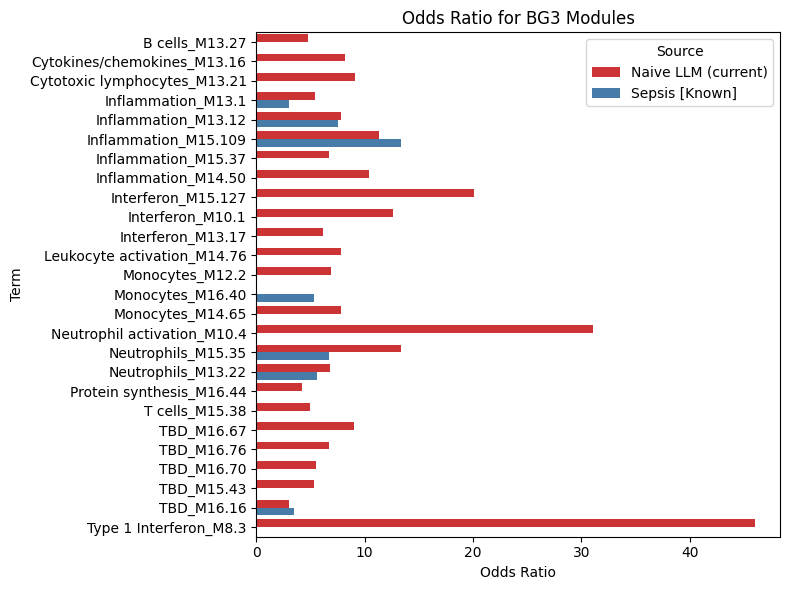

In [24]:
merge_bg3_enr
# barplot for bg3 enrichment
plt.figure(figsize=(8, 6))
sns.barplot(data=merge_bg3_enr, x='Odds Ratio', y='Term', hue='source', dodge=True, palette='Set1')
plt.ylabel('Term')
plt.title('Odds Ratio for BG3 Modules')
plt.legend(title='Source', loc='upper right')
plt.tight_layout()
plt.show()

## Figure 3D: Cluster wise enrichment

In [25]:
cluster_enrichment_msd = pd.DataFrame()
for cname, cgrp in naive_gene_score.groupby('qcut_percentile'):
    print (cname, ":", cgrp.shape[0], "genes")
    cgenes = cgrp.index.tolist()
    # perform enrichment analysis for each category
    enr_c = gp.enrichr(gene_list=cgenes, gene_sets=[msigdb_gs], organism='Human', cutoff=0.1)
    enr_c = enr_c.results.sort_values(by='Adjusted P-value', ascending=True)
    enr_c = enr_c[enr_c['Adjusted P-value'] < 0.1]  
    enr_c_ds = enr_c[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
    enr_c_ds['source'] = cname
    enr_c_ds['Category'] = enr_c_ds['Term'].map(pathway_category)
    enr_c_ds.sort_values(by=['Category','Adjusted P-value'], ascending=True, inplace=True)
    # add to dataframe
    cluster_enrichment_msd = pd.concat([cluster_enrichment_msd, enr_c_ds], axis=0, ignore_index=True)
    print ("---")

5 : 136 genes
---
4 : 120 genes
---
3 : 144 genes
---
2 : 109 genes
---
1 : 100 genes
---


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/113045421.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cname, cgrp in naive_gene_score.groupby('qcut_percentile'):


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/3924628101.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


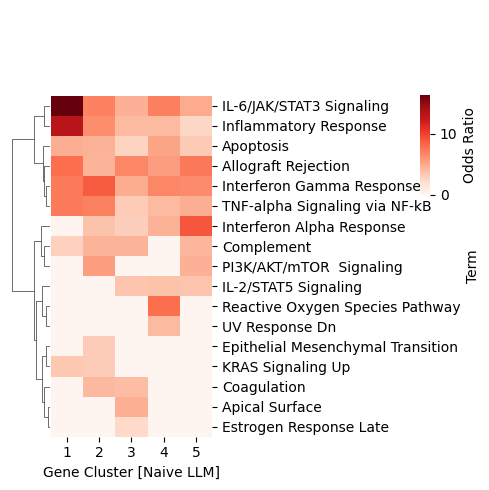

In [26]:
dx = cluster_enrichment_msd.pivot_table(index='source', columns='Term', values='Odds Ratio').fillna(0)
g = sns.clustermap(
    dx.T,
    method="ward",
    col_cluster=False,
    cmap="Reds",
    figsize=(5, 5),
    cbar_kws={"label": "Odds Ratio"},
)
# x-label as 'Cluster'
g.ax_heatmap.set_xlabel('Gene Cluster [Naive LLM]')
# cmap location 
cbar = g.ax_cbar
cbar.set_position([0.85, 0.6, 0.02, 0.2])
plt.tight_layout()
# plt.savefig("./output/Figures/Fig2D_naive_gene_cluster_msigdb_enrichment.pdf", dpi=300)
plt.show()

# PS1 _ popualrity factor : supplementary

In [27]:
# pubmed_df_
pubmed_df_nSelect = pubmed_df_[pubmed_df_['Input Symbol'].isin(naive_gene_score.index)]\
    [['gene_symbol_official','Input Symbol','Gene Name','count']].set_index('Input Symbol').copy()
pubmed_df_nSelect.head()  

,gene_symbol_official,Gene Name,count
Input Symbol,,,
PRDX6,PRDX6,peroxiredoxin 6,4
CD3D,CD3D,CD3 delta subunit of T-cell receptor complex,8
FN1,FN1,fibronectin 1,5
NLRP12,NLRP12,NLR family pyrin domain containing 12,5
C2,C2,complement C2,116


In [28]:
naive_gene_score['pubmed_count'] = pubmed_df_nSelect['count']
naive_gene_score['logCount'] = np.log10(naive_gene_score['pubmed_count'] + 1)  # Adding 1 to avoid log(0)
# min-max normlization for popularity
naive_gene_score['popularity'] = (naive_gene_score['logCount'] - naive_gene_score['logCount'].min()) / \
                                 (naive_gene_score['logCount'].max() - naive_gene_score['logCount'].min())

qcut_color_dict = naive_gene_score.groupby('qcut_percentile')['gene_cluster'].first().to_dict()
# change key to str
qcut_color_dict = {str(k): v for k, v in qcut_color_dict.items()}


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/4285917493.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  qcut_color_dict = naive_gene_score.groupby('qcut_percentile')['gene_cluster'].first().to_dict()


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/2814763642.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=naive_gene_score, x='qcut_percentile', y='popularity', palette=qcut_color_dict, ax=ax[0])
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/2814763642.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=naive_gene_score, x='qcut_percentile', y='logCount', palette=qcut_color_dict, ax=ax[1])
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/2814763642.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), ro

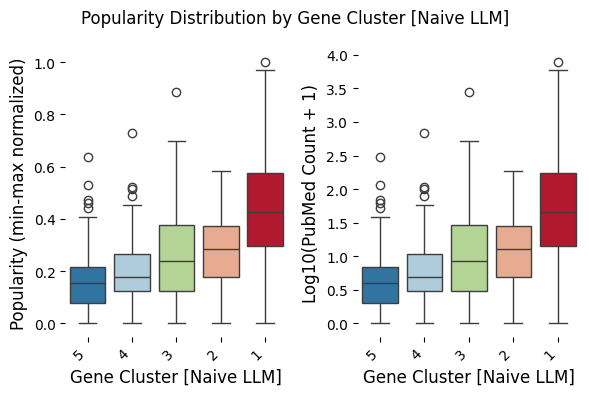

In [29]:
# make subplots for popularity and nlogCount
fig, ax = plt.subplots(1,2,figsize=(6, 4))
sns.boxplot(data=naive_gene_score, x='qcut_percentile', y='popularity', palette=qcut_color_dict, ax=ax[0])

ax[0].set_xlabel('Gene Cluster [Naive LLM]', fontsize=12)
ax[0].set_ylabel('Popularity (min-max normalized)', fontsize=12)
sns.boxplot(data=naive_gene_score, x='qcut_percentile', y='logCount', palette=qcut_color_dict, ax=ax[1])

ax[1].set_xlabel('Gene Cluster [Naive LLM]', fontsize=12)
ax[1].set_ylabel('Log10(PubMed Count + 1)', fontsize=12)
# Beautify plots
for a in ax:
    for spine in a.spines.values():
        spine.set_visible(False)
    a.tick_params(axis='both', which='major', labelsize=10)
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('Popularity Distribution by Gene Cluster [Naive LLM]', fontsize=12)
plt.tight_layout()
# plt.savefig("./output/Figures/Fig2supp_naive_gene_popularity_pubmed_count.pdf", dpi=300)
plt.show()

# PS2 [figure 3 top panel]: comparing RAG results and filtering liturature backed preference 

## Figure 4A: RAg evaluation

In [30]:
rago4_phi4_df.head()

,final_answer,final_score,scientific_explanation,output_tokens,total_tokens,model,query,naive_score,naive_justification,rag_score,...,RAG_Evaluation_Result,RAG_Reasoning,rag_usage.prompt_tokens,rag_usage.completion_tokens,rag_usage.total_tokens,RAG_evalutator,gene_qkey,hybrid_category,rag_category,naive_category
0,No,2.0,The Naive LLM Critic suggests that BTLA has po...,NaN,NaN,gpt-4o,The gene BTLA has potential value as a blood t...,4.0,BTLA (B and T Lymphocyte Attenuator) is an imm...,0,...,Fail,NO\n\nThe context does not mention the gene BT...,526,48,574,phi4,BTLA_sepsis_biomarker_blood,Low,Low,Medium
1,No,2.5,The naive LLM evidence suggests a potential ro...,124.0,629.0,gpt-4o,The gene IL10RA is associated with sepsis-rela...,5.0,IL10RA encodes the receptor for interleukin-10...,0,...,Fail,Information: The context does not provide any ...,2533,41,2574,NaN,IL10RA_sepsis_organ,Low,Low,Medium
2,Unclear,3.5,The Naive LLM Critic provides a moderate score...,182.0,728.0,gpt-4o,The gene IL15 is associated with the host immu...,7.0,IL15 is a cytokine involved in the regulation ...,0,...,Pass,To determine if the given piece of information...,2488,45,2533,NaN,IL15_sepsis_immune,None,Low,High
3,Unclear,2.0,"The Naive LLM Critic suggests that NFKBIB, whi...",169.0,700.0,gpt-4o,The gene NFKBIB is associated with sepsis-rela...,4.0,"NFKBIB encodes IκBβ, a protein involved in the...",0,...,Fail,NO\n\nThe context discusses an insertion delet...,2547,44,2591,NaN,NFKBIB_sepsis_organ,Low,Low,Medium
4,No,0.0,The naive LLM evidence suggests a potential ro...,NaN,NaN,gpt-4o,The gene SLAMF1 is associated with sepsis-rela...,3.0,SLAMF1 (Signaling Lymphocytic Activation Molec...,0,...,Fail,NO\n\nThe context does not mention the gene SL...,940,41,981,phi4,SLAMF1_sepsis_organ,Low,Low,Low


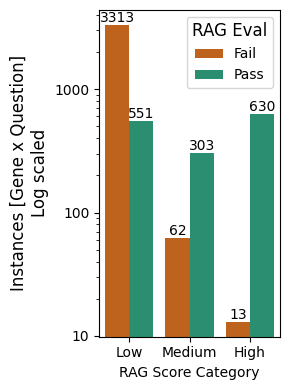

In [31]:
import matplotlib.ticker as ticker

status_colors = {'Pass': '#1b9e77', 'Fail': '#d95f02'}  # teal / orange
# Create a single plot for RAG category
plt.figure(figsize=(3, 4))
ax = sns.countplot(data=rago4_phi4_df, x='rag_category', hue='RAG_Evaluation_Result', 
                   order=['Low', 'Medium', 'High'], palette=status_colors)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Add bar heights as text labels
for p in ax.patches:
    if int(p.get_height()) == 0:
        continue

    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Set y-axis ticks explicitly to match the original numbers
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

plt.legend(title='RAG Eval', loc='upper right', fontsize=10, title_fontsize=12)
# Set labels and title
ax.set_xlabel('RAG Score Category')
ax.set_ylabel('Instances [Gene x Question]\nLog scaled', fontdict={'fontsize': 12})
plt.tight_layout()
# plt.savefig("./output/Figures/Fig4A_rago4_phi4_rag_category.pdf", dpi=300)

plt.show()

In [32]:
rago4_phi4_ss_pass = rago4_phi4_df[rago4_phi4_df.RAG_Evaluation_Result == "Pass"].copy().reset_index(drop=True)
print ("Shape of rago4_phi4_ss_pass:", rago4_phi4_ss_pass.shape)
print ("Number of unique genes in rago4_phi4_ss_pass:", rago4_phi4_ss_pass.gene_name.nunique())

Shape of rago4_phi4_ss_pass: (1484, 26)
Number of unique genes in rago4_phi4_ss_pass: 455


In [33]:
rago4_phi4_ss_pass['naive_cluster'] = rago4_phi4_ss_pass['gene_name'].map(naive_gene_score['qcut_percentile'])

In [34]:
clusterWiseConut = naive_gene_score.groupby('qcut_percentile').size().to_frame()
clusterWiseConut.rename(columns={0: 'nLLM'}, inplace=True)
clusterWiseConut['RAG'] = rago4_phi4_ss_pass.groupby("naive_cluster")['gene_name'].nunique()
clusterWiseConut['pct_Recovery'] = (clusterWiseConut['RAG'] / clusterWiseConut['nLLM']) * 100
print ("Cluster-wise Recovery Percentage:")
clusterWiseConut[['nLLM', 'RAG', 'pct_Recovery']]


Cluster-wise Recovery Percentage:


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/3382114314.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clusterWiseConut = naive_gene_score.groupby('qcut_percentile').size().to_frame()
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/3382114314.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clusterWiseConut['RAG'] = rago4_phi4_ss_pass.groupby("naive_cluster")['gene_name'].nunique()


,nLLM,RAG,pct_Recovery
qcut_percentile,,,
5,136,82,60.294118
4,120,72,60.000000
3,144,109,75.694444
2,109,99,90.825688
1,100,93,93.000000


## Figure 4B : gene recovery by RAG as compare to PS1 cluster

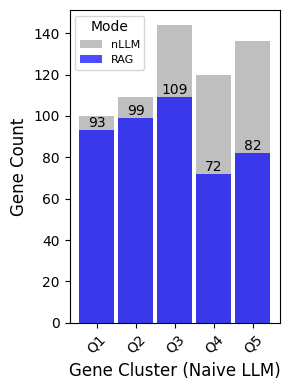

In [35]:
plt.figure(figsize=(3, 4))

# Plot NaiveCluster in gray
plt.bar(clusterWiseConut.index, clusterWiseConut['nLLM'], color='gray', label='nLLM', alpha=0.5,width=0.9)

# Overlay RAG_pass in blue
bars = plt.bar(clusterWiseConut.index, clusterWiseConut['RAG'], color='blue', label='RAG', alpha=0.7, width=0.9)

# Add numbers on top of blue bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10, color='black')

# Add labels and legend
plt.xlabel('Gene Cluster (Naive LLM)', fontsize=12)
plt.ylabel('Gene Count', fontsize=12)
# plt.title('NaiveCluster vs RAG_pass', fontsize=14)
plt.legend(title='Mode', fontsize=8, loc='upper left')
plt.xticks(clusterWiseConut.index, [f'Q{i}' for i in clusterWiseConut.index], rotation=45)
plt.tight_layout()

# plt.savefig("./output/Figures/Fig4B_naive_cluster_rag_pass.pdf", dpi=300)
plt.show()

## Figure 4C : performance comparision

In [55]:
!pip install scikit-learn --quiet

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

### Naive Vs RAG

In [37]:
sepsis_results = rago4_phi4_ss_pass[['gene_name','json_key','hybrid_category','rag_category','naive_category','naive_cluster']]
# naive vr rag
merge_matrix = pd.DataFrame()
confusion_matrix_a = pd.crosstab(   sepsis_results['naive_category'], 
    sepsis_results['rag_category'],
    rownames=['Naive Category'],
    colnames=['RAG Category'],
)
# print accuracy percentage
agreement_a = confusion_matrix_a.values.diagonal().sum() / confusion_matrix_a.values.sum() * 100
print(f"Percentage of agreement between Hybrid Score Category and RAG Score Category (Pass): {agreement_a:.2f}%")
accuracy_matrix = {'naive_rag':{'Overall':agreement_a}}
confusion_matrix_a['Cluter'] = "Overall"
# add confusion matrix to merge_matrix
merge_matrix = pd.concat([merge_matrix, confusion_matrix_a], axis=1)
for ncluster in sorted(list(sepsis_results.naive_cluster.unique())):
    print ("Naive Cluster:", ncluster)
    confusion_matrix_a_cluster = pd.crosstab(   sepsis_results[sepsis_results.naive_cluster == ncluster]['naive_category'], 
        sepsis_results[sepsis_results.naive_cluster == ncluster]['rag_category'],
        rownames=['Naive Category'],
        colnames=['RAG Category'],
    )
    # merge on the columns
    confusion_matrix_a_cluster['Cluster'] = ncluster
    merge_matrix = pd.concat([merge_matrix, confusion_matrix_a_cluster], axis=1)
    # print accuracy percentage
    agreement_a_cluster = confusion_matrix_a_cluster.values.diagonal().sum() / confusion_matrix_a_cluster.values.sum() * 100
    print(f"Percentage of agreement between Hybrid Score Category and RAG Score Category (Pass): {agreement_a_cluster:.2f}%")
    accuracy_matrix['naive_rag'].update({f'{ncluster}':agreement_a_cluster})

Percentage of agreement between Hybrid Score Category and RAG Score Category (Pass): 45.69%
Naive Cluster: 1
Percentage of agreement between Hybrid Score Category and RAG Score Category (Pass): 64.39%
Naive Cluster: 2
Percentage of agreement between Hybrid Score Category and RAG Score Category (Pass): 37.85%
Naive Cluster: 3
Percentage of agreement between Hybrid Score Category and RAG Score Category (Pass): 35.22%
Naive Cluster: 4
Percentage of agreement between Hybrid Score Category and RAG Score Category (Pass): 31.02%
Naive Cluster: 5
Percentage of agreement between Hybrid Score Category and RAG Score Category (Pass): 45.51%


### Naive Vs HybridLLM

In [38]:
# naive vs hybrid
# cluster-wise naive vs hybrid
merge_matrix_b = pd.DataFrame()

confusion_matrix_b = pd.crosstab(sepsis_results['naive_category'], 
    sepsis_results['hybrid_category'],
    rownames=['Naive Category'],
    colnames=['Hybrid Category'],
)
# print accuracy percentage
agreement_b = confusion_matrix_b.values.diagonal().sum() / confusion_matrix_b.values.sum() * 100
print(f"Percentage of agreement between Naive Score Category and Hybrid Score Category: {agreement_b:.2f}%")
accuracy_matrix['naive_hybrid'] = {'Overall': agreement_b}  
# Display the confusion matrix in tabular format
confusion_matrix_b['Cluster'] = "Overall"
# add confusion matrix to merge_matrix
merge_matrix_b = pd.concat([merge_matrix_b, confusion_matrix_b], axis=1)


for ncluster in sepsis_results.naive_cluster.unique():
    print ("Naive Cluster:", ncluster)
    confusion_matrix_b_cluster = pd.crosstab(   sepsis_results[sepsis_results.naive_cluster == ncluster]['naive_category'], 
        sepsis_results[sepsis_results.naive_cluster == ncluster]['hybrid_category'],
        rownames=['Naive Category'],
        colnames=['Hybrid Category'],
    )
    # merge on the columns
    confusion_matrix_b_cluster['Cluster'] = ncluster
    merge_matrix_b = pd.concat([merge_matrix_b, confusion_matrix_b_cluster], axis=1)
    # print accuracy percentage
    agreement_b_cluster = confusion_matrix_b_cluster.values.diagonal().sum() / confusion_matrix_b_cluster.values.sum() * 100
    print(f"Percentage of agreement between Naive Score Category and Hybrid Score Category (Pass): {agreement_b_cluster:.2f}%")
    accuracy_matrix['naive_hybrid'].update({f'{ncluster}':agreement_b_cluster})
    
# merge_matrix_b.to_csv("./output/tables/naive_hybrid_confusion_matrix.csv")


Percentage of agreement between Naive Score Category and Hybrid Score Category: 51.56%
Naive Cluster: 3
Percentage of agreement between Naive Score Category and Hybrid Score Category (Pass): 40.75%
Naive Cluster: 1
Percentage of agreement between Naive Score Category and Hybrid Score Category (Pass): 68.87%
Naive Cluster: 2
Percentage of agreement between Naive Score Category and Hybrid Score Category (Pass): 45.20%
Naive Cluster: 4
Percentage of agreement between Naive Score Category and Hybrid Score Category (Pass): 36.31%
Naive Cluster: 5
Percentage of agreement between Naive Score Category and Hybrid Score Category (Pass): 49.43%


### RAG Vs HybridLLM

In [39]:
# rag vs hybrid
# cluster-wise rag vs hybrid
merge_matrix_c = pd.DataFrame()

confusion_matrix_c = pd.crosstab(   sepsis_results['rag_category'], 
    sepsis_results['hybrid_category'],
    rownames=['RAG Category'],
    colnames=['Hybrid Category'],
)
# print accuracy percentage
agreement_c = confusion_matrix_c.values.diagonal().sum() / confusion_matrix_c.values.sum() * 100
print(f"Percentage of agreement between RAG Score Category and Hybrid Score Category: {agreement_c:.2f}%")
accuracy_matrix['rag_hybrid'] = {'Overall': agreement_c}  
confusion_matrix_c['Cluster'] = "Overall"
# add confusion matrix to merge_matrix
merge_matrix_c = pd.concat([merge_matrix_c, confusion_matrix_c], axis=1)



for ncluster in sepsis_results.naive_cluster.unique():
    print ("Naive Cluster:", ncluster)
    confusion_matrix_c_cluster = pd.crosstab(   sepsis_results[sepsis_results.naive_cluster == ncluster]['rag_category'], 
        sepsis_results[sepsis_results.naive_cluster == ncluster]['hybrid_category'],
        rownames=['RAG Category'],
        colnames=['Hybrid Category'],
    )
    # merge on the columns
    confusion_matrix_c_cluster['Cluster'] = ncluster
    merge_matrix_c = pd.concat([merge_matrix_c, confusion_matrix_c_cluster], axis=1)
    # print accuracy percentage
    agreement_c_cluster = confusion_matrix_c_cluster.values.diagonal().sum() / confusion_matrix_c_cluster.values.sum() * 100
    print(f"Percentage of agreement between RAG Score Category and Hybrid Score Category (Pass): {agreement_c_cluster:.2f}%")
    accuracy_matrix['rag_hybrid'].update({f'{ncluster}':agreement_c_cluster})
    
# merge_matrix_c.to_csv("./output/tables/rag_hybrid_confusion_matrix.csv")

Percentage of agreement between RAG Score Category and Hybrid Score Category: 96.22%
Naive Cluster: 3
Percentage of agreement between RAG Score Category and Hybrid Score Category (Pass): 94.18%
Naive Cluster: 1
Percentage of agreement between RAG Score Category and Hybrid Score Category (Pass): 96.92%
Naive Cluster: 2
Percentage of agreement between RAG Score Category and Hybrid Score Category (Pass): 93.50%
Naive Cluster: 4
Percentage of agreement between RAG Score Category and Hybrid Score Category (Pass): 88.83%
Naive Cluster: 5
Percentage of agreement between RAG Score Category and Hybrid Score Category (Pass): 85.63%


### compose all

In [40]:
cl_Cat = {'5': '#1f78b4',
 '4': '#a6cee3',
 '3': '#b2df8a',
 '2': '#f4a582',
 '1': '#ca0020',
 'Overall': '#0b0b0b'}
 # plot accuracy matrix
accuracy_df = pd.DataFrame(accuracy_matrix).T
accuracy_df = accuracy_df.reset_index().rename(columns={'index': 'Comparison'})
accuracy_df = accuracy_df.melt(id_vars='Comparison', var_name='Cluster', value_name='Agreement Rate (%)')
accuracy_df['Cluster'] = accuracy_df['Cluster'].fillna('Overall')

In [41]:
accuracy_df['Comparison'] = accuracy_df['Comparison'].map({
    'naive_rag': 'Naive vs RAG',
    'naive_hybrid': 'Naive vs Hybrid',
    'rag_hybrid': 'RAG vs Hybrid'
})

### Figure

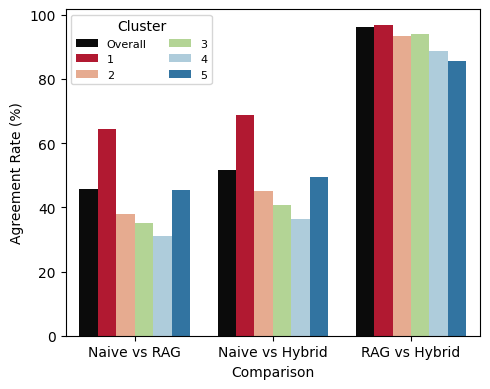

In [42]:

plt.figure(figsize=(5, 4))
sns.barplot(data=accuracy_df, x='Comparison', y='Agreement Rate (%)', hue='Cluster', palette=cl_Cat, hue_order=['Overall', '1', '2', '3', '4', '5'])
plt.ylabel('Agreement Rate (%)')
plt.xlabel('Comparison')
plt.xticks(rotation=0)
plt.legend(title='Cluster', fontsize=8, title_fontsize=10, loc='upper left',ncols=2)
plt.tight_layout()
# save figure
# plt.savefig("./output/Figures/Fig4C_agreement_rate_comparison.pdf", dpi=300)
plt.show()

# PS2 [Figure 3 bottom panel] clustering filtering and dynamics

In [43]:
rago4_phi4_df[rago4_phi4_df.RAG_Evaluation_Result=="Pass"].gene_name.nunique()

455

In [44]:
gene_score_hybrid = pd.DataFrame(index=rago4_phi4_df.gene_name.unique())
# add naive score
gene_score_hybrid['naive_wt_score'] = getgenWise_wt_score(rago4_phi4_df,'naive_category')
# add hybrid score
gene_score_hybrid['hybrid_wt_score'] = getgenWise_wt_score(rago4_phi4_df[rago4_phi4_df.RAG_Evaluation_Result=="Pass"],'hybrid_category')
# add rag score
gene_score_hybrid['rag_wt_score'] = getgenWise_wt_score(rago4_phi4_df[rago4_phi4_df.RAG_Evaluation_Result=="Pass"],'rag_category')
gene_score_hybrid

,naive_wt_score,hybrid_wt_score,rag_wt_score
BTLA,0.6375,0.925000,1.0
IL10RA,0.6750,NaN,0.3
IL15,0.7250,0.433333,0.4
NFKBIB,0.6500,0.300000,0.3
SLAMF1,0.5000,0.300000,0.3
...,...,...,...
CD24,0.9250,0.700000,0.7
FGL2,0.8875,0.300000,0.3
MIR223,0.8875,0.900000,0.9
NFE2L2,0.8875,NaN,NaN


## RAG pass but hybrid fail

In [45]:
gene_score_hybrid[(gene_score_hybrid.rag_wt_score > 0)&(gene_score_hybrid.hybrid_wt_score.isna())]

,naive_wt_score,hybrid_wt_score,rag_wt_score
IL10RA,0.6750,NaN,0.3
PTPRC,0.5750,NaN,0.3
SIGIRR,0.7250,NaN,0.3
FGA,0.6375,NaN,0.3
LTA,0.6875,NaN,0.3
GAS6,0.8875,NaN,0.3
CXCR3,0.7250,NaN,0.3
CLEC4E,0.7625,NaN,0.3
ISG15,0.8000,NaN,0.3
MFGE8,0.8875,NaN,0.3


In [46]:
gclustering = pd.DataFrame(index=gene_score_hybrid.index)
gclustering['HybridLLM_cluster'] = pd.qcut(gene_score_hybrid['hybrid_wt_score'].dropna(), q=5, duplicates='drop', labels=[4,3,2,1])
gclustering['NaiveLLM_cluster'] = naive_gene_score['qcut_percentile']

# add scores
gclustering['NaiveLLM_score'] = naive_gene_score['naive_score_wt']
gclustering['HybridLLM_score'] = gene_score_hybrid['hybrid_wt_score'] 
# Add 'Fail' to the categories of HybridLLM_cluster
gclustering['HybridLLM_cluster'] = gclustering['HybridLLM_cluster'].cat.add_categories(['Fail'])

# Fill missing values with 'Fail'
gclustering['HybridLLM_cluster'] = gclustering['HybridLLM_cluster'].fillna("Fail")

In [47]:
gclustering.head()

,HybridLLM_cluster,NaiveLLM_cluster,NaiveLLM_score,HybridLLM_score
BTLA,1,4,0.6375,0.925000
IL10RA,Fail,3,0.6750,NaN
IL15,4,3,0.7250,0.433333
NFKBIB,4,3,0.6500,0.300000
SLAMF1,4,5,0.5000,0.300000


## Figure 4D [snakey plot for chnage in cluster dynamics between PS1 and PS2]

In [ ]:
!pip install plotly --quiet
!pip install nbformat --quiet

In [48]:
import plotly.graph_objects as go

# Define your color mapping for clusters
cl_Cat = {'5': '#1f78b4',
 '4': '#a6cee3',
 '3': '#b2df8a',
 '2': '#f4a582',
 '1': '#ca0020',
 'Fail': '#0b0b0b'}


import random
genes = gclustering.index.tolist()
naive_clusters = pd.Series(gclustering['NaiveLLM_cluster'].astype(str),  index=gclustering.index)
hybrid_clusters = pd.Series(gclustering['HybridLLM_cluster'].astype(str),  index=gclustering.index)

# Build a DataFrame for mapping
df_sankey = pd.DataFrame({
    'gene': gclustering.index,
    'naive_cluster': naive_clusters,
    'hybrid_cluster': hybrid_clusters
})

# Count overlaps
overlap_counts = df_sankey.groupby(['naive_cluster', 'hybrid_cluster']).size().reset_index(name='count')

# Prepare Sankey node labels
naive_labels = sorted(df_sankey['naive_cluster'].unique())
hybrid_labels = sorted(df_sankey['hybrid_cluster'].unique())
labels = naive_labels + hybrid_labels

# Map cluster names to node indices
naive_idx = {k: i for i, k in enumerate(naive_labels)}
hybrid_idx = {k: i+len(naive_labels) for i, k in enumerate(hybrid_labels)}

# Build source, target, value lists
sources = overlap_counts['naive_cluster'].map(naive_idx)
targets = overlap_counts['hybrid_cluster'].map(hybrid_idx)
values = overlap_counts['count']

# Assign colors to nodes based on cl_Cat
node_colors = [cl_Cat.get(str(l), '#cccccc') for l in labels]
# Create Sankey plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

# Add annotations for Naive LLM and Hybrid LLM
# fig.add_annotation(
#     x=0.05, y=0.5, text="Naive LLM", showarrow=False, font=dict(size=12, color="black")
# )
# fig.add_annotation(
#     x=0.95, y=0.5, text="Hybrid LLM", showarrow=False, font=dict(size=12, color="black")
# )

# fig.update_layout(title_text="Cluster Overlap: NaiveLLM vs Hybrid LLM (Sankey Plot)", font_size=12)
fig.update_layout(
    # title_text="Cluster Overlap: NaiveLLM vs Hybrid LLM (Sankey Plot)",
    # font_size=12,
    width=300,   # set width in pixels
    height=400   # set height in pixels
)
fig
# fig.write_image("./output/Figures/Fig4sankey_naive_hybrid.png", format="png", width=600, height=400, scale=2)

Figure Title:
Sankey Diagram of Cluster Overlap Between NaiveLLM and Hybrid LLM Gene Assignments

Legend:
This Sankey diagram visualizes the overlap in gene cluster assignments between the NaiveLLM and Hybrid LLM approaches. Each node on the left represents a cluster assigned by the NaiveLLM, while each node on the right represents a cluster assigned by the Hybrid LLM. The width of each flow (link) is proportional to the number of genes shared between the corresponding clusters. Node colors correspond to cluster categories, with the following color mapping:

5: Blue (#1f78b4)
4: Light Blue (#a6cee3)
3: Green (#b2df8a)
2: Orange (#f4a582)
1: Red (#ca0020)
Fail: Black (#0b0b0b)
This plot highlights how gene groupings change between the two methods, allowing for easy comparison of cluster consistency and reassignments.

In [49]:
hybridLLM_genes = gclustering[gclustering.HybridLLM_cluster !="Fail"].index.unique()
print ("Hybrid LLM genes:", len(hybridLLM_genes))

Hybrid LLM genes: 442


In [50]:
gclustering_ss = gclustering[gclustering.HybridLLM_cluster !="Fail"].copy()

##  Figure 4 (E & F) [Pathway enrichment]

### E :MolSigDB 

In [51]:
# for whole sepsis genes
enr_msigdb_whole = gp.enrichr(gene_list=list(sepsis_whole), gene_sets=[msigdb_gs], organism='Human', cutoff=0.05)
enr_msigdb_whole = enr_msigdb_whole.results.sort_values(by='Adjusted P-value', ascending=True)
enr_msigdb_whole = enr_msigdb_whole[enr_msigdb_whole['Adjusted P-value'] < 0.05]

# for nllm genes
enr_msigdb_nllm = gp.enrichr(gene_list=list(nllm_gs), gene_sets=[msigdb_gs], organism='Human', cutoff=0.05)
enr_msigdb_nllm = enr_msigdb_nllm.results.sort_values(by='Adjusted P-value', ascending=True)
enr_msigdb_nllm = enr_msigdb_nllm[enr_msigdb_nllm['Adjusted P-value'] < 0.05]   

# for Hybrid LLM genes
enr_msigdb_hybrid = gp.enrichr(gene_list=list(hybridLLM_genes), gene_sets=[msigdb_gs], organism='Human', cutoff=0.05)
enr_msigdb_hybrid = enr_msigdb_hybrid.results.sort_values(by='Adjusted P-value', ascending=True)
enr_msigdb_hybrid = enr_msigdb_hybrid[enr_msigdb_hybrid['Adjusted P-value'] < 0.05]

# print results
print("Enriched MSigDB Hallmark terms for whole sepsis genes:")
print(enr_msigdb_whole.shape[0], "terms found")
print("Enriched MSigDB Hallmark terms for NLLM genes:")
print(enr_msigdb_nllm.shape[0], "terms found")
print("Enriched MSigDB Hallmark terms for Hybrid LLM genes:")
print(enr_msigdb_hybrid.shape[0], "terms found")


Enriched MSigDB Hallmark terms for whole sepsis genes:
12 terms found
Enriched MSigDB Hallmark terms for NLLM genes:
16 terms found
Enriched MSigDB Hallmark terms for Hybrid LLM genes:
14 terms found


In [52]:
enr_msigdb_whole_ds = enr_msigdb_whole[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
enr_msigdb_nllm_ds = enr_msigdb_nllm[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
enr_msigdb_hybrid_ds = enr_msigdb_hybrid[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()

# map category
pathway_category = {
    'Interferon Gamma Response': 'Inflammatory / Cytokine Signaling',
    'Allograft Rejection': 'Adaptive / Alloimmunity',
    'Inflammatory Response': 'General Immune Activation',
    'TNF-alpha Signaling via NF-kB': 'Inflammatory / Cytokine Signaling',
    'IL-6/JAK/STAT3 Signaling': 'Inflammatory / Cytokine Signaling',
    'Complement': 'Complement / Coagulation',
    'Apoptosis': 'Cell Stress / Death',
    'Interferon Alpha Response': 'Inflammatory / Cytokine Signaling',
    'IL-2/STAT5 Signaling': 'Inflammatory / Cytokine Signaling',
    'Coagulation': 'Complement / Coagulation',
    'PI3K/AKT/mTOR  Signaling': 'Signal Transduction',
    'KRAS Signaling Up': 'Signal Transduction',
    'Epithelial Mesenchymal Transition': 'Tissue Remodeling / EMT',
    'Hypoxia': 'Cell Stress / Death',
    'Reactive Oxygen Species Pathway': 'Cell Stress / Death',
    'Oxidative Phosphorylation': 'Cell Stress / Death',
    'TGF-beta Signaling': 'Signal Transduction'
}



enr_msigdb_whole_ds['Category'] = enr_msigdb_whole_ds["Term"].map(pathway_category)
enr_msigdb_nllm_ds['Category'] = enr_msigdb_nllm_ds["Term"].map(pathway_category)
enr_msigdb_hybrid_ds['Category'] = enr_msigdb_hybrid_ds["Term"].map(pathway_category)

enr_msigdb_whole_ds.sort_values(by=['Category','Adjusted P-value'], ascending=True, inplace=True)
enr_msigdb_nllm_ds.set_index('Term',inplace=True)
enr_msigdb_whole_ds.set_index('Term',inplace=True)
enr_msigdb_hybrid_ds.set_index('Term', inplace=True)

enr_msigdb_nllm_ds['Source'] = 'NaiveLLM'
enr_msigdb_whole_ds['Source'] = 'SepsisDB'
enr_msigdb_hybrid_ds['Source'] = 'HybridLLM'

# concatenate the three dataframes
enr_msigdb_combined = pd.concat([enr_msigdb_nllm_ds, 
                                  enr_msigdb_whole_ds,
                                  enr_msigdb_hybrid_ds],
                                 axis=0, ignore_index=False)
enr_msigdb_combined.reset_index(inplace=True)
enr_msigdb_combined.head()

,Term,index,Overlap,Adjusted P-value,Odds Ratio,Category,Source
0,Interferon Gamma Response,25,90/200,1.730044e-41,10.042216,Inflammatory / Cytokine Signaling,NaiveLLM
1,Allograft Rejection,1,88/200,8.365873e-40,9.579990,Adaptive / Alloimmunity,NaiveLLM
2,Inflammatory Response,23,77/200,8.544192e-30,7.365124,General Immune Activation,NaiveLLM
3,TNF-alpha Signaling via NF-kB,41,73/200,1.575688e-26,6.677523,Inflammatory / Cytokine Signaling,NaiveLLM
4,IL-6/JAK/STAT3 Signaling,22,46/87,8.300640e-25,12.272316,Inflammatory / Cytokine Signaling,NaiveLLM


In [80]:
!pip install altair --quiet

In [53]:
import altair as alt

# Create a scatter chart with Altair
msd_cx = alt.Chart(enr_msigdb_combined).mark_point(filled=True).encode(
    x=alt.X('Source',sort=['SepsisDB', 'NaiveLLM', 'HybridLLM'], title='Source'),
    y=alt.Y("Term:O"),
    color=alt.Color('Odds Ratio', scale=alt.Scale(scheme='reds')),
    size=alt.Size('Adjusted P-value', scale=alt.Scale(range=[10, 200],reverse=True), title='Adjusted P-value'),
    tooltip=['Term', 'Overlap', 'Adjusted P-value', 'Odds Ratio', 'Source']
).properties(
    width=60,
    height=300,
    title='MSigDB Hallmark Pathway Enrichment'
)

msd_cx

alt.Chart(...)

### Figure 5A [PS2 geen cluster wise enrichment]

4 : 177 genes
---
3 : 91 genes
---
2 : 92 genes
---
1 : 82 genes
---
Fail : 0 genes
Skipping Fail cluster


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/1014513556.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/1014513556.py:38: UserWarning:

Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations



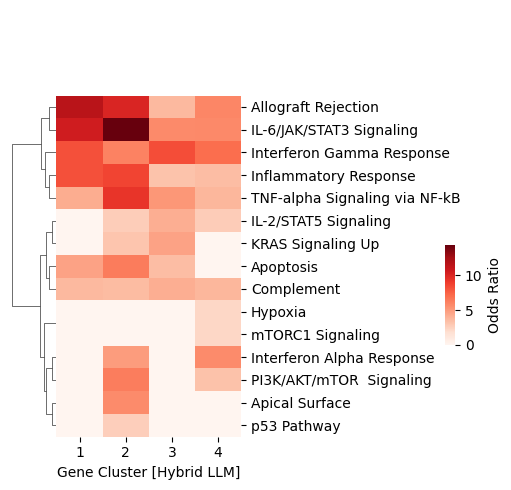

In [54]:
# cluster enrichment for MSigDB Hallmark terms
cluster_enrichment_msd = pd.DataFrame()
for cname, cgrp in gclustering_ss.groupby('HybridLLM_cluster'):
    print (cname, ":", cgrp.shape[0], "genes")
    cgenes = cgrp.index.tolist()
    if cname == "Fail":
        print ("Skipping Fail cluster")
        continue
    # perform enrichment analysis for each category
    enr_c = gp.enrichr(gene_list=cgenes, gene_sets=[msigdb_gs], organism='Human', cutoff=0.1)
    enr_c = enr_c.results.sort_values(by='Adjusted P-value', ascending=True)
    enr_c = enr_c[enr_c['Adjusted P-value'] < 0.1]  
    enr_c_ds = enr_c[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
    enr_c_ds['source'] = cname
    enr_c_ds['Category'] = enr_c_ds['Term'].map(pathway_category)
    enr_c_ds.sort_values(by=['Category','Adjusted P-value'], ascending=True, inplace=True)
    # add to dataframe
    cluster_enrichment_msd = pd.concat([cluster_enrichment_msd, enr_c_ds], axis=0, ignore_index=True)
    print ("---")

dx = cluster_enrichment_msd.pivot_table(index='source', columns='Term', values='Odds Ratio').fillna(0)
g = sns.clustermap(
dx.T,
method="ward",
col_cluster=False,
cmap="Reds",
figsize=(5, 5),
cbar_kws={"label": "Odds Ratio"},
)
# x-label as 'Cluster'
g.ax_heatmap.set_xlabel('Gene Cluster [Hybrid LLM]')
# no y-lable
g.ax_heatmap.set_ylabel('')

# cmap location 
cbar = g.ax_cbar
cbar.set_position([0.9, 0.3, 0.02, 0.2])
plt.tight_layout()
# plt.savefig("./output/Figures/Fig2D_Hybrid_gene_cluster_msigdb_enrichment.pdf", dpi=300)
plt.show()

🔍 Narrative Comparison: Naive LLM vs. Hybrid (RAG+) Pipeline

1️⃣ Gene Retention and Re-Scoring (Sankey Plot Insight)
Transitioning from the Naive LLM to the Hybrid RAG+ pipeline, which incorporates literature-grounded context, results in a high retention rate: 480 out of 608 genes (~79%) remain concordant with the Naive model's selections. The Sankey plot illustrates how genes redistributed across clusters when re-scored with the literature-augmented Hybrid model. Although a substantial portion of the high-confidence genes (Cluster 1 in Naive) remain within high-weight clusters in Hybrid, there is clear gene migration across clusters, indicating that literature grounding leads to both reinforced confidence for some genes and re-prioritization for others.

2️⃣ Global Pathway Enrichment (Bar Plot Comparison)
When comparing pathway enrichment between Naive LLM, Hybrid LLM (RAG+), and SepsisDB benchmarks:

Key inflammatory and immune signaling pathways (IL-6/JAK/STAT3, TNF-alpha, Interferon Gamma Response, Allograft Rejection) continue to show strong enrichment across all models, confirming their core relevance to sepsis biology.

The Hybrid pipeline shows increased odds ratios for certain pathways (e.g., Apoptosis, Interferon Alpha Response, Coagulation), reflecting the Hybrid’s ability to elevate biologically grounded processes that were somewhat underweighted in the Naive model.

Conversely, pathways like Oxidative Phosphorylation and Reactive Oxygen Species Pathway, which were modestly enriched in Naive, show further deprioritization in the Hybrid model, potentially indicating correction of non-specific stress signatures.

3️⃣ Cluster-Wise Functional Profiles (Heatmap Comparison)
Comparing the new heatmap (Hybrid) with the previous Naive version:

IL-6/JAK/STAT3, Interferon Gamma Response, and Inflammation pathways are even more sharply concentrated in the top clusters (Clusters 1 and 2) in the Hybrid model, reinforcing their prominence.

The Hybrid heatmap displays cleaner separation and stronger odds ratios for primary immune and signaling pathways, suggesting that RAG+ grounding improves biological focus.

Some pathways visible in Naive (like UV Response Dn and Estrogen Response Late) are absent or less prominent in the Hybrid heatmap, reflecting reduction of noise or less relevant signals.

Notably, mTORC1 signaling and PI3K/AKT/mTOR signaling appear more prominent in the Hybrid pipeline, suggesting an elevated appreciation of growth and survival signaling pathways, which have mechanistic ties to immune regulation and sepsis pathology.

🧠 Key Takeaway
The shift from Naive to Hybrid (RAG+) produces greater biological specificity, with increased enrichment strength in canonical immune and inflammatory pathways.

The Hybrid model preserves core immune signaling identified by the Naive pipeline but refines the focus by removing diffuse or less relevant stress-related pathways and better highlighting mechanistically grounded pathways.

The overall consistency across both models with the SepsisDB benchmark underscores the robustness of the LLM-guided approach, while the Hybrid framework further optimizes biological relevance.



### F : bloodGen3

In [55]:
# whole sepsis genes enrichment for BG3
enr_bg3_whole = gp.enrichr(gene_list=list(sepsis_whole), gene_sets=[bg3_modules], organism='Human', cutoff=0.05)
enr_bg3_whole = enr_bg3_whole.results.sort_values(by='Adjusted P-value', ascending=True)
enr_bg3_whole = enr_bg3_whole[enr_bg3_whole['Adjusted P-value'] < 0.05]  
# for nllm genes enrichment for BG3

enr_bg3_nllm = gp.enrichr(gene_list=list(nllm_gs), gene_sets=[bg3_modules], organism='Human', cutoff=0.05)
enr_bg3_nllm = enr_bg3_nllm.results.sort_values(by='Adjusted P-value', ascending=True)
enr_bg3_nllm = enr_bg3_nllm[enr_bg3_nllm['Adjusted P-value'] < 0.05]  

# hybrid LLM genes enrichment for BG3
enr_bg3_hybrid = gp.enrichr(gene_list=list(hybridLLM_genes), gene_sets=[bg3_modules], organism='Human', cutoff=0.05)
enr_bg3_hybrid = enr_bg3_hybrid.results.sort_values(by='Adjusted P-value', ascending=True)
enr_bg3_hybrid = enr_bg3_hybrid[enr_bg3_hybrid['Adjusted P-value'] < 0.05]



enr_bg3_nllm_ds = enr_bg3_nllm[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
enr_bg3_whole_ds = enr_bg3_whole[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()
enr_bg3_hybrid_ds = enr_bg3_hybrid[['Term','Overlap','Adjusted P-value','Odds Ratio']].reset_index()

enr_bg3_whole_ds['source'] = 'SepsisDB'
enr_bg3_nllm_ds['source'] = 'NaiveLLM'
enr_bg3_hybrid_ds['source'] = 'HybridLLM'

merge_bg3_enr = pd.concat([enr_bg3_whole_ds,enr_bg3_nllm_ds,enr_bg3_hybrid_ds],axis=0, ignore_index=True)
merge_bg3_enr['Category'] = merge_bg3_enr['Term'].apply(lambda x: x.split('_')[0] if '_' in x else 'Other')
merge_bg3_enr.sort_values(by=['Category','Adjusted P-value'], ascending=True, inplace=True)


In [56]:
cx = alt.Chart(merge_bg3_enr,width=60, height=400).mark_point(filled=True).encode(
    x=alt.X('source', title='gene source'),
    y=alt.Y('Term', title='BG3 (Module-Title)'),
    color=alt.Color('Odds Ratio', scale=alt.Scale(scheme='reds',domain=[0,12], clamp=True), title='Odds Ratio'),
    size=alt.Size('Adjusted P-value', scale=alt.Scale(range=[10, 200],reverse=True)),
    tooltip=['Term', 'Odds Ratio', 'Adjusted P-value', 'Overlap', 'source']
).properties(
    title='BG3 Module Enrichment Analysis'
).interactive().configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
)

cx

alt.Chart(...)

In [57]:
gclustering_ss.sort_values(by=['HybridLLM_score','HybridLLM_score'], ascending=[False,True], inplace=True)
gclustering_ss

,HybridLLM_cluster,NaiveLLM_cluster,NaiveLLM_score,HybridLLM_score
IFIH1,1,5,0.5500,1.0
ADAM17,1,1,0.8500,1.0
CD247,1,5,0.4000,1.0
C5AR1,1,1,0.9625,1.0
ROCK1,1,3,0.6875,1.0
...,...,...,...,...
ESM1,4,1,0.8875,0.3
CARD8,4,5,0.5500,0.3
MYLK,4,3,0.7250,0.3
FCAR,4,5,0.5000,0.3


# PS3 [top cluster of PS2]

In [58]:
hybrid_scoreMat = rago4_phi4_ss_pass[rago4_phi4_ss_pass.gene_name.isin(gclustering_ss.index)].pivot_table(index='gene_name', 
                               columns='json_key', 
                               values='final_score')
hybrid_scoreMat['Hybrid_cluster'] = gclustering_ss['HybridLLM_cluster']
hybrid_scoreMat.sort_values(by='Hybrid_cluster', ascending=False, inplace=True)
print ("Shape of hybrid score matrix:", hybrid_scoreMat.shape)

hybrid_scoreMat_x = hybrid_scoreMat[hybrid_scoreMat.columns[:-1]].fillna(0).copy().astype(float)

ps3_genes = hybrid_scoreMat_x.loc[gclustering_ss[gclustering_ss.HybridLLM_cluster ==1].index]
print ("PS3 genes [Hybrid LLM Cluster 1]:" )
print (ps3_genes.shape[0], "genes")

Shape of hybrid score matrix: (442, 9)
PS3 genes [Hybrid LLM Cluster 1]:
82 genes


In [59]:
# update PS2 gene list
gene_set_dict.update({'PS2_gene_HybridLLM': hybrid_scoreMat.index.tolist()})
# update PS3 gene list
gene_set_dict.update({'PS3_gene_HybridLLM': ps3_genes.index.tolist()})
#update redData.index
gene_set_dict.update({'redData_5source': refData.index.tolist()})

print ("Updated gene set dictionary with PS2 and PS3 genes for Hybrid LLM:")
for k, v in gene_set_dict.items():
    print(f"{k}: {len(v)} genes")

Updated gene set dictionary with PS2 and PS3 genes for Hybrid LLM:
PS1_gene_naiveLLM: 609 genes
known_genes: 929 genes
PS2_gene_HybridLLM: 442 genes
PS3_gene_HybridLLM: 82 genes
redData_5source: 507 genes


# Candidate Genes : re-clustering of PS3

## Figure 5B

Cluster: 1
Cluster: 0
Cluster: 2
Cluster: 3


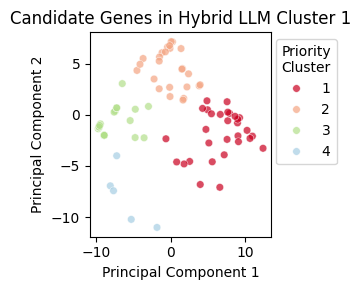

In [60]:
# perform unsupervised clustering on the top candidate genes
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(ps3_genes)
# perform unsupervised clustering like hdbscan      
clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = clustering.fit_predict(pca_result)
# Create a DataFrame for the PCA results and clustering labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels
pca_df['genes'] = ps3_genes.index
# Plot the PCA results with clustering labels
top_candicate_rep = pd.DataFrame()

for c in pca_df['Cluster'].unique():
    print ("Cluster:", c)
    genes = pca_df[pca_df['Cluster'] == c]['genes'].tolist()
    top_candicate_rep[c] = ps3_genes.loc[genes].median().T

# Calculate mean values for each cluster
cluster_means = top_candicate_rep.mean().sort_values(ascending=False)

# Create a mapping for relabeling clusters
relabel_mapping = {old_label: new_label for new_label, old_label in enumerate(cluster_means.index, start=1)}

# Relabel clusters in the DataFrame
top_candicate_rep.columns = top_candicate_rep.columns.map(relabel_mapping)

pca_df['priority_cluster'] = pca_df['Cluster'].map(relabel_mapping)

priority_cluster_color = {1: '#ca0020', 2: '#f4a582',
                          3: '#b2df8a', 4: '#a6cee3',
                          5: '#1f78b4'}

plt.figure(figsize=(4, 3))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='priority_cluster', 
                palette=priority_cluster_color, s=30, alpha=0.7, legend='full')
plt.title('Candidate Genes in Hybrid LLM Cluster 1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Priority\nCluster', loc='upper right',bbox_to_anchor=(1.4, 1))

plt.tight_layout()

## Figure 5C [polar plot with mean score]

/Users/khant/JaX_work/RAG_projects/Sepsis/app/sepsis_rag/lib/python3.12/site-packages/seaborn/matrix.py:1113: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



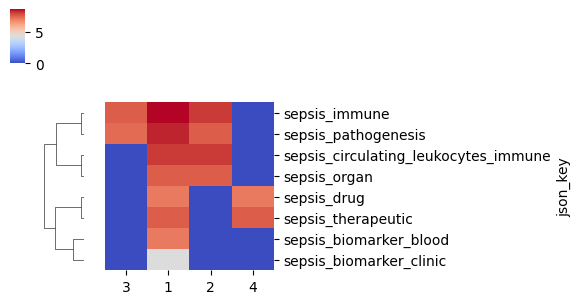

In [61]:
g = sns.clustermap(top_candicate_rep,row_cluster=True, col_cluster=False, figsize=(3,3),cmap="coolwarm",)

In [62]:
pca_df.groupby('priority_cluster').size()

priority_cluster
1    30
2    25
3    22
4     5
dtype: int64

In [63]:
# Create figure
df = g.data2d.copy()
df_data = df[sorted(df.columns)]
df_data

,1,2,3,4
json_key,,,,
sepsis_immune,8.50,8.0,7.50,0.0
sepsis_pathogenesis,8.25,7.5,7.25,0.0
sepsis_circulating_leukocytes_immune,8.00,8.0,0.00,0.0
sepsis_organ,7.50,7.5,0.00,0.0
sepsis_drug,7.00,0.0,0.00,7.0
sepsis_therapeutic,7.50,0.0,0.00,7.5
sepsis_biomarker_blood,7.00,0.0,0.00,0.0
sepsis_biomarker_clinic,4.25,0.0,0.00,0.0


Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4


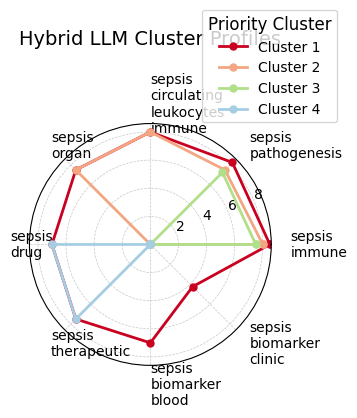

In [64]:
# Create figure with polar projection
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=dict(projection='polar'))

# Define angles for each sepsis topic (evenly distributed around circle)
# Ensure topics are valid keys in the data object
topics = df_data.index.tolist()
angles = np.linspace(0, 2*np.pi, len(topics), endpoint=False)

priority_cluster_color = {1: '#ca0020', 2: '#f4a582',
                          3: '#b2df8a', 4: '#a6cee3',
                          5: '#1f78b4'}

# Plot each cluster as a line on the polar plot
for i, cluster in enumerate(df_data.columns):
    print ("Cluster:", cluster)
    # Get the data for the current cluster
    cluster_data = df_data[cluster].values
    # Ensure the data is circular by appending the first value to the end
    cluster_data = np.concatenate((cluster_data, [cluster_data[0]]))
    # Plot the data
    ax.plot(np.concatenate((angles, [angles[0]])), cluster_data, label=f'Cluster {cluster}', 
            color=priority_cluster_color[int(cluster)], linewidth=2, marker='o', markersize=5)  
# Set the labels for each angle
ax.set_xticks(angles)  # Ensure the number of ticks matches the number of labels
ax.set_xticklabels([tx.replace("_","\n") for tx in topics], fontsize=10, rotation=45, ha='left')
# Set the radial limits
ax.set_ylim(0, df_data.max().max() + 0.1)
# Add a title
ax.set_title('Hybrid LLM Cluster Profiles', fontsize=14, pad=20)
# Add a legend
ax.legend(title='Priority Cluster', loc='upper right', bbox_to_anchor=(1.3, 1.5), fontsize=10, title_fontsize=12)
# Add grid lines
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()


In [65]:
priority_geneset = pca_df[pca_df.priority_cluster == 1].sort_values(by='PC1', ascending=False).genes.values
print ("Priority genes in Hybrid LLM Cluster 1:")
print (len(priority_geneset), "genes")

Priority genes in Hybrid LLM Cluster 1:
30 genes


In [66]:
# update candidate data with priority genes
#update redData.index
gene_set_dict.update({'candidate_genes': priority_geneset})

In [67]:
_common = set(gene_set_dict['known_genes']).intersection(priority_geneset)
print ("Common genes in Sepsis known genes and Hybrid LLM Cluster 1:", len(_common))
print ("Common genes in Sepsis known genes and Hybrid LLM Cluster 1:", _common)
# unique in Hybrid LLM Cluster 1
unique_hybrid = set(priority_geneset) - set(gene_set_dict['known_genes'])
print ("Unique genes in Hybrid LLM Cluster 1:", len(unique_hybrid))
print ("Unique genes in Hybrid LLM Cluster 1:", unique_hybrid)

Common genes in Sepsis known genes and Hybrid LLM Cluster 1: 28
Common genes in Sepsis known genes and Hybrid LLM Cluster 1: {'CD14', 'HMGB1', 'SIRT1', 'ADAM10', 'C5AR1', 'IRAK3', 'CX3CR1', 'PDCD1', 'LBP', 'TLR4', 'HMOX1', 'VWF', 'TREM1', 'PTX3', 'HIF1A', 'NLRP3', 'IL10', 'NFKB1', 'CXCR2', 'ADAM17', 'ANGPT2', 'STAT3', 'ADM', 'PFKFB3', 'C5', 'CD40LG', 'S100A9', 'LCN2'}
Unique genes in Hybrid LLM Cluster 1: 2
Unique genes in Hybrid LLM Cluster 1: {'HDAC6', 'CD38'}


In [68]:
_common = set(refData.index).intersection(priority_geneset)
print ("Common genes in RefData and Hybrid LLM Cluster 1:", len(_common))
print ("Common genes in RefData and Hybrid LLM Cluster 1:", _common)
# unique in Hybrid LLM Cluster 1
unique_hybrid = set(priority_geneset) - set(refData.index)
print ("Unique genes in Hybrid LLM Cluster 1:", len(unique_hybrid))
print ("Unique genes in Hybrid LLM Cluster 1:", unique_hybrid)

Common genes in RefData and Hybrid LLM Cluster 1: 19
Common genes in RefData and Hybrid LLM Cluster 1: {'CD14', 'HMGB1', 'SIRT1', 'C5AR1', 'PDCD1', 'LBP', 'TLR4', 'HMOX1', 'TREM1', 'PTX3', 'NLRP3', 'IL10', 'CXCR2', 'ANGPT2', 'ADM', 'C5', 'CD40LG', 'S100A9', 'LCN2'}
Unique genes in Hybrid LLM Cluster 1: 11
Unique genes in Hybrid LLM Cluster 1: {'ADAM10', 'IRAK3', 'NFKB1', 'VWF', 'CX3CR1', 'ADAM17', 'STAT3', 'HDAC6', 'CD38', 'PFKFB3', 'HIF1A'}


## Figure 5D [Clustered heatmap]

In [69]:
knowledge_state = pd.DataFrame(index=list(priority_geneset))
knowledge_state.loc[list(_common),'knowledge status'] = '#1b9e77'
knowledge_state.loc[list(unique_hybrid),'knowledge status'] = '#d95f02'

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_40878/381517852.py:21: UserWarning:

Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations



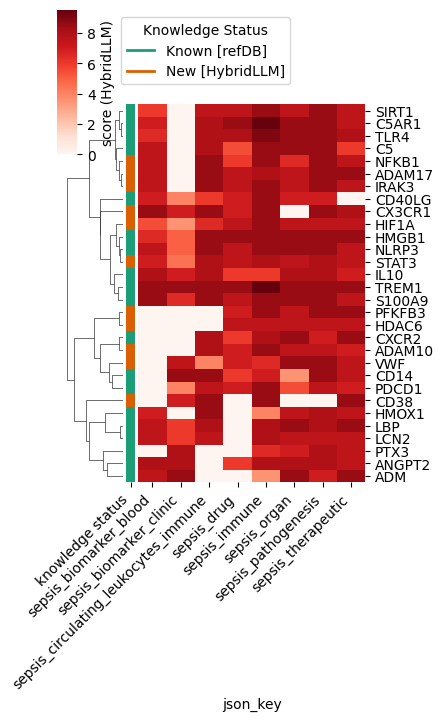

In [70]:
prioritySet = ps3_genes.loc[priority_geneset]

# make clustermap
g = sns.clustermap(prioritySet,
                method="ward",
                cmap="Reds",
                figsize=(4, 8),
                cbar_kws={"label": "score (HybridLLM)"},
                col_cluster=False,
                row_colors= knowledge_state['knowledge status'],
                )
#make legend color
plt.legend(handles=[
    plt.Line2D([0], [0], color='#1b9e77', lw=2, label='Known [refDB]'),
    plt.Line2D([0], [0], color='#d95f02', lw=2, label='New [HybridLLM]')
], fontsize=10, bbox_to_anchor=(12, 1), title='Knowledge Status')
# rotate x labels by 45 with hs=right
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
plt.setp(g.ax_row_colors.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=10)
plt.tight_layout()

# rotate color baer labes also by same

# plt.savefig("./output/Figures/Fig4C_priority_genes_hybrid_clustermap.pdf", dpi=300)
plt.show()

# Conclusion

In [71]:
# final gene set al differentr levels
print ("Final gene set dictionary:")
for k, v in gene_set_dict.items():
    print(f"{k}: {len(v)} genes")

Final gene set dictionary:
PS1_gene_naiveLLM: 609 genes
known_genes: 929 genes
PS2_gene_HybridLLM: 442 genes
PS3_gene_HybridLLM: 82 genes
redData_5source: 507 genes
candidate_genes: 30 genes


In [72]:
# gene sets dataframe
gene_dict = []
for k, v in gene_set_dict.items():
    gene_dict.append((k, len(v), ",".join(v)))

gene_sets_df = pd.DataFrame(gene_dict, columns=['Gene Set', 'Gene Count', 'Gene List'])

In [73]:
gene_sets_df.sort_values(by='Gene Count', ascending=False, inplace=True)

In [74]:
gene_sets_df

,Gene Set,Gene Count,Gene List
1,known_genes,929,"CD14,LMOD1,NDUFB10,RAC2,BPI,MIR193B,CHD7,GJB6,..."
0,PS1_gene_naiveLLM,609,"IL10,IL6,CD14,MIF,TNF,TREM1,HMGB1,ANGPT2,IL6R,..."
4,redData_5source,507,"APLN,RPL9,IL27,EXTL3,PROC,MT-ND6,CTCF,KCNQ1OT1..."
2,PS2_gene_HybridLLM,442,"ADAM10,FASLG,HMOX1,HMGB1,SIRT1,SIRT3,HIF1A,HDA..."
3,PS3_gene_HybridLLM,82,"IFIH1,ADAM17,CD247,C5AR1,ROCK1,ICAM1,HP,CD38,A..."
5,candidate_genes,30,"TREM1,S100A9,HMGB1,NLRP3,C5AR1,IL10,STAT3,TLR4..."


In [129]:
gene_sets_df.to_csv("./output/tables/final_gene_sets.csv", index=False)

In [76]:
gclustering

,HybridLLM_cluster,NaiveLLM_cluster,NaiveLLM_score,HybridLLM_score
BTLA,1,4,0.6375,0.925000
IL10RA,Fail,3,0.6750,NaN
IL15,4,3,0.7250,0.433333
NFKBIB,4,3,0.6500,0.300000
SLAMF1,4,5,0.5000,0.300000
...,...,...,...,...
CD24,3,1,0.9250,0.700000
FGL2,4,1,0.8875,0.300000
MIR223,2,1,0.8875,0.900000
NFE2L2,Fail,1,0.8875,NaN


In [79]:
pca_df.set_index('genes', inplace=True)
pca_df

,PC1,PC2,Cluster,priority_cluster
genes,,,,
IFIH1,-7.423820,0.365190,1,3
ADAM17,8.952119,-0.792374,0,1
CD247,-7.568988,0.260552,1,3
C5AR1,9.226433,-0.282584,0,1
ROCK1,-4.735379,0.540883,1,3
...,...,...,...,...
VWF,5.570652,-4.593761,0,1
PDCD1,4.724020,-1.427332,0,1
NFKB1,7.650743,0.254862,0,1


In [83]:
gclustering_all = gclustering.join(pca_df[['PC1','PC2',"priority_cluster"]], how='left')

In [85]:
gclustering_all.sort_values(by="priority_cluster")

,HybridLLM_cluster,NaiveLLM_cluster,NaiveLLM_score,HybridLLM_score,PC1,PC2,priority_cluster
PFKFB3,1,4,0.6000,1.000000,2.542759,-4.560039,1.0
IRAK3,1,1,0.9250,0.912500,8.622816,-0.153234,1.0
CX3CR1,1,3,0.7250,1.000000,7.172416,-3.913620,1.0
HIF1A,1,1,0.8500,0.914286,7.555806,-2.405184,1.0
PDCD1,1,4,0.6375,0.914286,4.724020,-1.427332,1.0
...,...,...,...,...,...,...,...
GRN,Fail,4,0.6375,NaN,NaN,NaN,NaN
CD24,3,1,0.9250,0.700000,NaN,NaN,NaN
FGL2,4,1,0.8875,0.300000,NaN,NaN,NaN
MIR223,2,1,0.8875,0.900000,NaN,NaN,NaN


In [86]:
gclustering_all.to_csv("../data/PS1_to_Candidate_Sepsis_genes.csv", index=True)

alt.Chart(...)

In [88]:
# altair scatter plot for priority clusters
priority_cluster_color = {1: '#ca0020', 2: '#f4a582',
                          3: '#b2df8a', 4: '#a6cee3',
                          5: '#1f78b4'}
priority_scatter = alt.Chart(gclustering_all.reset_index()).mark_point(filled=True).encode(
    x=alt.X('PC1', title='Principal Component 1'),
    y=alt.Y('PC2', title='Principal Component 2'),
    color=alt.Color('priority_cluster:N', scale=alt.Scale(domain=list(priority_cluster_color.keys()), range=list(priority_cluster_color.values())), title='Priority Cluster'),
    tooltip=['index:N', 'PC1', 'PC2', 'priority_cluster']
).properties(
    width=400,
    height=400,
    title='Candidate Genes in Hybrid LLM Cluster 1'
).interactive().configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
)

priority_scatter

alt.Chart(...)

In [110]:
import plotly.graph_objects as go

# Define your color mapping for clusters
cl_Cat = {'5': '#1f78b4',
 '4': '#a6cee3',
 '3': '#b2df8a',
 '2': '#f4a582',
 '1': '#ca0020',
 'Fail': '#0b0b0b'}


import random
genes = gclustering_all.index.tolist()
naive_clusters = pd.Series(gclustering_all['NaiveLLM_cluster'].astype(str),  index=gclustering_all.index)
hybrid_clusters = pd.Series(gclustering_all['HybridLLM_cluster'].astype(str),  index=gclustering_all.index)

# Build a DataFrame for mapping
df_sankey = pd.DataFrame({
    'gene': gclustering.index,
    'naive_cluster': naive_clusters,
    'hybrid_cluster': hybrid_clusters
})

# Count overlaps
overlap_counts = df_sankey.groupby(['naive_cluster', 'hybrid_cluster']).size().reset_index(name='count')

# Prepare Sankey node labels
naive_labels = sorted(df_sankey['naive_cluster'].unique())
hybrid_labels = sorted(df_sankey['hybrid_cluster'].unique())
labels = naive_labels + hybrid_labels

# Map cluster names to node indices
naive_idx = {k: i for i, k in enumerate(naive_labels)}
hybrid_idx = {k: i+len(naive_labels) for i, k in enumerate(hybrid_labels)}

# Build source, target, value lists
sources = overlap_counts['naive_cluster'].map(naive_idx)
targets = overlap_counts['hybrid_cluster'].map(hybrid_idx)
values = overlap_counts['count']

# Assign colors to nodes based on cl_Cat
node_colors = [cl_Cat.get(str(l), '#cccccc') for l in labels]
# Create Sankey plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    ))])

# Add annotations for Naive LLM and Hybrid LLM with rotation
fig.add_annotation(
    x=-0.14, y=0.5, text="Naive LLM clusters", showarrow=False, font=dict(size=14, color="black"), textangle=90
)
fig.add_annotation(
    x=1.2, y=0.5, text="Hybrid LLM clusters", showarrow=False, font=dict(size=14, color="black"), textangle=90
)

# fig.update_layout(title_text="Cluster Overlap: NaiveLLM vs Hybrid LLM (Sankey Plot)", font_size=12)
fig.update_layout(
    # title_text="Cluster Overlap: NaiveLLM vs Hybrid LLM (Sankey Plot)",
    # font_size=12,
    width=300,   # set width in pixels
    height=400   # set height in pixels
)
fig

# Random checking

In [114]:
rago4_phi4_df[rago4_phi4_df.gene_name.isin(priority_geneset)].gene_name.nunique()

30

In [115]:
rago4_phi4_df[rago4_phi4_df.gene_name.isin(priority_geneset)].gene_name.unique()

array(['CD14', 'ADAM17', 'S100A9', 'STAT3', 'C5AR1', 'C5', 'SIRT1',
       'NLRP3', 'IL10', 'CXCR2', 'HMGB1', 'CD38', 'LCN2', 'HIF1A',
       'CX3CR1', 'TREM1', 'TLR4', 'PFKFB3', 'HMOX1', 'ADAM10', 'VWF',
       'PDCD1', 'IRAK3', 'NFKB1', 'HDAC6', 'LBP', 'CD40LG', 'PTX3', 'ADM',
       'ANGPT2'], dtype=object)

In [116]:
rago4_phi4_df[rago4_phi4_df.gene_name=="HMOX1"]

,final_answer,final_score,scientific_explanation,output_tokens,total_tokens,model,query,naive_score,naive_justification,rag_score,...,RAG_Evaluation_Result,RAG_Reasoning,rag_usage.prompt_tokens,rag_usage.completion_tokens,rag_usage.total_tokens,RAG_evalutator,gene_qkey,hybrid_category,rag_category,naive_category
490,No,3.0,"The Naive LLM Critic suggests that HMOX1, enco...",177.0,710.0,gpt-4o,The gene HMOX1 is a known drug target for seps...,6.0,"HMOX1, encoding heme oxygenase-1, is involved ...",0,...,Fail,NO\n\nThe context provided does not mention HM...,1815,55,1870,NaN,HMOX1_sepsis_drug,Low,Low,Medium
2390,No,0.0,The Naive LLM Critic suggests that HMOX1 has p...,190.0,700.0,gpt-4o,The gene HMOX1 or its products are currently b...,6.0,HMOX1 has been studied as a potential biomarke...,0,...,Fail,NO\n\nThe context does not mention the gene HM...,2403,47,2450,NaN,HMOX1_sepsis_biomarker_clinic,Low,Low,Medium
3612,Unclear,4.0,The Naive LLM Critic provides a strong argumen...,168.0,688.0,gpt-4o,The gene HMOX1 is associated with the host imm...,8.0,"HMOX1, encoding heme oxygenase-1, is well-docu...",0,...,Pass,Information: The context provided does not men...,2439,44,2483,NaN,HMOX1_sepsis_immune,Medium,Low,High
4226,Yes,8.0,Both the Naive LLM and Retrieved Context evide...,NaN,NaN,gpt-4o,The gene symbol HMOX1 or gene name heme oxygen...,8.0,"HMOX1, encoding heme oxygenase-1, is involved ...",8,...,Pass,YES\n\nThe context provides strong evidence th...,964,110,1074,phi4,HMOX1_sepsis_pathogenesis,High,High,High
4252,Yes,7.5,Both the Naive LLM and Retrieved Context evide...,NaN,NaN,gpt-4o,The gene symbol HMOX1 or gene name heme oxygen...,7.0,"HMOX1, encoding heme oxygenase-1, is involved ...",8,...,Pass,YES\n\nThe context provides support for the in...,933,111,1044,phi4,HMOX1_sepsis_organ,High,High,High
4321,Unclear,7.0,Both the Naive LLM and Retrieved Context analy...,NaN,NaN,gpt-4o,The gene symbol HMOX1 or gene name heme oxygen...,7.0,"HMOX1, encoding heme oxygenase-1, is known to ...",7,...,Pass,YES\n\nThe context provides evidence that HMOX...,850,102,952,phi4,HMOX1_sepsis_biomarker_blood,High,High,High
4376,Yes,8.5,Both the Naive LLM and Retrieved Context evide...,NaN,NaN,gpt-4o,The gene symbol HMOX1 or gene name heme oxygen...,7.0,"HMOX1, encoding heme oxygenase-1, is known to ...",8,...,Pass,YES\n\nThe context provides evidence supportin...,1019,115,1134,phi4,HMOX1_sepsis_circulating_leukocytes_immune,High,High,High
4830,Yes,7.5,Both the Naive LLM and Retrieved Context evide...,NaN,NaN,gpt-4o,The gene symbol HMOX1 or gene name heme oxygen...,7.0,"HMOX1, encoding heme oxygenase-1, has been imp...",8,...,Pass,YES\n\nThe context provides multiple pieces of...,1367,122,1489,phi4,HMOX1_sepsis_therapeutic,High,High,High
